# Peter in volk: Uvod v okrepljeno učenje

V tem vodiču se bomo naučili, kako uporabiti okrepljeno učenje za reševanje problema iskanja poti. Zgodba je navdihnjena z glasbeno pravljico [Peter in volk](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) ruskega skladatelja [Sergeja Prokofjeva](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Gre za zgodbo o mladem pionirju Petru, ki pogumno zapusti svojo hišo in se odpravi na gozdno jaso, da bi lovil volka. Naučili bomo algoritme strojnega učenja, ki bodo Petru pomagali raziskati okolico in zgraditi optimalen navigacijski zemljevid.

Najprej uvozimo nekaj uporabnih knjižnic:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Pregled učenja z okrepitvijo

**Učenje z okrepitvijo** (RL) je tehnika učenja, ki nam omogoča, da se naučimo optimalnega vedenja **agenta** v nekem **okolju** z izvajanjem številnih poskusov. Agent v tem okolju mora imeti določen **cilj**, ki ga opredeljuje **funkcija nagrajevanja**.

## Okolje

Za enostavnost si predstavljajmo Peterjev svet kot kvadratno ploščo velikosti `width` x `height`. Vsaka celica na tej plošči je lahko:
* **zemlja**, po kateri lahko Peter in druga bitja hodijo
* **voda**, po kateri se seveda ne more hoditi
* **drevo** ali **trava** - mesto, kjer se lahko spočiješ
* **jabolko**, ki predstavlja nekaj, kar bi Peter z veseljem našel, da se nahrani
* **volk**, ki je nevaren in se mu je treba izogniti

Za delo z okoljem bomo definirali razred `Board`. Da ne bi preveč obremenili tega zvezka, smo ves kodo za delo s ploščo premaknili v ločen modul `rlboard`, ki ga bomo zdaj uvozili. Več podrobnosti o notranji implementaciji si lahko ogledate znotraj tega modula.


In [2]:
from rlboard import *

Zdaj ustvarimo naključno ploščo in si oglejmo, kako izgleda:


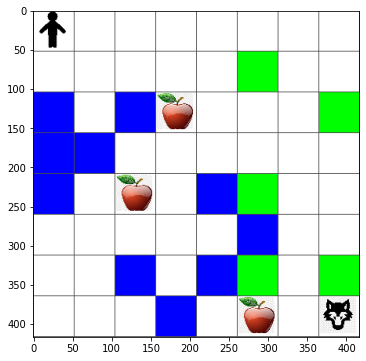

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Dejanja in Pravila

V našem primeru je Peterjev cilj najti jabolko, medtem ko se izogiba volku in drugim oviram. Da bi to dosegel, se lahko preprosto sprehaja, dokler ne najde jabolka. Tako lahko na katerem koli položaju izbere eno od naslednjih dejanj: gor, dol, levo in desno. Ta dejanja bomo definirali kot slovar in jih preslikali v pare ustreznih sprememb koordinat. Na primer, premik v desno (`R`) bi ustrezal paru `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategija našega agenta (Peter) je določena z tako imenovano **politiko**. Poglejmo najpreprostejšo politiko, imenovano **naključna hoja**.

## Naključna hoja

Najprej rešimo naš problem z implementacijo strategije naključne hoje.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Pojdimo večkrat izvesti poskus naključnega sprehoda in si oglejmo povprečno število opravljenih korakov:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funkcija nagrajevanja

Da bi naša politika postala bolj inteligentna, moramo razumeti, kateri premiki so "boljši" od drugih.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Učenje

Ustvarite Q-tabelo ali večdimenzionalno matriko. Ker ima naša plošča dimenzije `width` x `height`, lahko Q-tabelo predstavimo z numpy matriko oblike `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Podajte Q-tabelo funkciji za risanje, da vizualizirate tabelo na plošči:


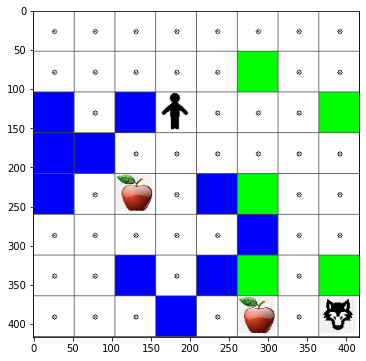

In [9]:
m.plot(Q)

## Bistvo Q-Učenja: Bellmanova enačba in učni algoritem

Napišite psevdokodo za naš učni algoritem:

* Inicializirajte Q-tabelo Q z enakimi vrednostmi za vsa stanja in akcije
* Nastavite stopnjo učenja $\alpha\leftarrow 1$
* Večkrat ponovite simulacijo
   1. Začnite na naključni poziciji
   1. Ponavljajte
        1. Izberite akcijo $a$ v stanju $s$
        2. Izvedite akcijo z premikom v novo stanje $s'$
        3. Če naletimo na pogoj konca igre ali je skupna nagrada premajhna - zaključite simulacijo  
        4. Izračunajte nagrado $r$ v novem stanju
        5. Posodobite Q-funkcijo v skladu z Bellmanovo enačbo: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Posodobite skupno nagrado in zmanjšajte $\alpha$.

## Izkoriščanje vs. Raziskovanje

Najboljši pristop je uravnotežiti med raziskovanjem in izkoriščanjem. Ko se več naučimo o našem okolju, bomo bolj verjetno sledili optimalni poti, vendar se občasno odločimo za nepreizkušeno pot.

## Python Implementacija

Zdaj smo pripravljeni implementirati učni algoritem. Pred tem potrebujemo tudi funkcijo, ki bo poljubne številke v Q-tabeli pretvorila v vektor verjetnosti za ustrezne akcije:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Dodamo majhno količino `eps` k prvotnemu vektorju, da se izognemo deljenju z 0 v začetnem primeru, ko so vse komponente vektorja enake.

Dejanski učni algoritem bomo izvedli za 5000 poskusov, imenovanih tudi **epoh**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Po izvedbi tega algoritma bi morala biti Q-tabela posodobljena z vrednostmi, ki določajo privlačnost različnih dejanj na vsakem koraku. Vizualizirajte tabelo tukaj:


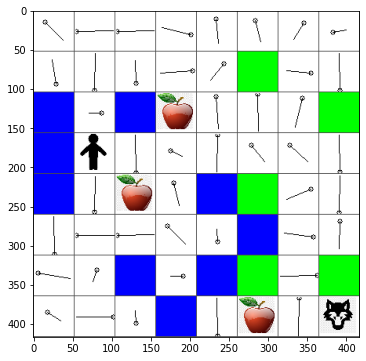

In [12]:
m.plot(Q)

## Preverjanje politike

Ker Q-Table prikazuje "privlačnost" vsakega dejanja v vsakem stanju, ga je zelo enostavno uporabiti za določanje učinkovite navigacije v našem svetu. V najpreprostejšem primeru lahko preprosto izberemo dejanje, ki ustreza najvišji vrednosti v Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Če večkrat preizkusite zgornjo kodo, boste opazili, da se včasih preprosto "zatakne" in morate pritisniti gumb STOP v beležnici, da jo prekinete.

> **Naloga 1:** Spremenite funkcijo `walk`, da omejite največjo dolžino poti na določeno število korakov (recimo 100), in opazujte, kako zgornja koda občasno vrne to vrednost.

> **Naloga 2:** Spremenite funkcijo `walk`, da se ne vrača na mesta, kjer je že bila prej. To bo preprečilo, da bi se `walk` zanka, vendar se agent še vedno lahko "ujame" na lokaciji, iz katere ne more pobegniti.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


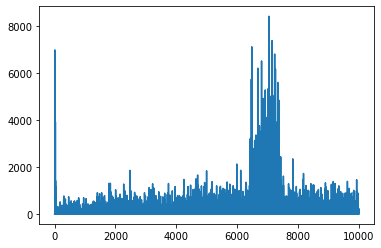

In [15]:
plt.plot(lpath)

Kar vidimo tukaj, je, da se je povprečna dolžina poti sprva povečala. To je verjetno posledica dejstva, da ko o okolju ne vemo ničesar, se zlahka ujamemo v slaba stanja, kot so voda ali volk. Ko se naučimo več in začnemo uporabljati to znanje, lahko okolje raziskujemo dlje, vendar še vedno ne vemo dobro, kje so jabolka.

Ko se dovolj naučimo, postane agentu lažje doseči cilj, dolžina poti pa začne upadati. Vendar smo še vedno odprti za raziskovanje, zato pogosto odstopamo od najboljše poti in raziskujemo nove možnosti, kar podaljša pot nad optimalno dolžino.

Na tem grafu opazimo tudi, da se je dolžina na neki točki nenadoma povečala. To kaže na stohastično naravo procesa in na to, da lahko na neki točki "pokvarimo" koeficiente Q-tabele, tako da jih prepišemo z novimi vrednostmi. To bi morali idealno zmanjšati z znižanjem učne stopnje (tj. proti koncu učenja prilagajamo vrednosti Q-tabele le za majhno vrednost).

Na splošno je pomembno vedeti, da uspeh in kakovost učnega procesa močno odvisna od parametrov, kot so učna stopnja, zmanjševanje učne stopnje in faktor diskonta. Ti se pogosto imenujejo **hiperparametri**, da jih ločimo od **parametrov**, ki jih optimiziramo med učenjem (npr. koeficienti Q-tabele). Proces iskanja najboljših vrednosti hiperparametrov se imenuje **optimizacija hiperparametrov**, in si zasluži ločeno obravnavo.


## Vaja
#### Bolj realističen svet Petra in volka

V naši situaciji se je Peter lahko premikal skoraj brez utrujenosti ali lakote. V bolj realističnem svetu se mora občasno ustaviti, da si odpočije, in se tudi nahraniti. Naredimo naš svet bolj realističen z uvedbo naslednjih pravil:

1. Ko se Peter premika iz enega kraja v drugega, izgublja **energijo** in pridobiva **utrujenost**.
2. Peter lahko pridobi več energije z uživanjem jabolk.
3. Peter se lahko znebi utrujenosti tako, da počiva pod drevesom ali na travi (tj. ko stopi na polje z drevesom ali travo - zeleno polje).
4. Peter mora najti in ubiti volka.
5. Da bi ubil volka, mora Peter imeti določene ravni energije in utrujenosti, sicer izgubi boj.

Spremenite zgornjo funkcijo nagrajevanja v skladu s pravili igre, zaženite algoritem za okrepitev učenja, da se naučite najboljše strategije za zmago v igri, in primerjajte rezultate naključnega premikanja z vašim algoritmom glede na število zmag in porazov.

> **Opomba**: Morda boste morali prilagoditi hiperparametre, da bo delovalo, še posebej število epoh. Ker je uspeh igre (boj z volkom) redek dogodek, lahko pričakujete precej daljši čas učenja.



---

**Omejitev odgovornosti**:  
Ta dokument je bil preveden z uporabo storitve za strojno prevajanje [Co-op Translator](https://github.com/Azure/co-op-translator). Čeprav si prizadevamo za natančnost, vas prosimo, da se zavedate, da lahko avtomatizirani prevodi vsebujejo napake ali netočnosti. Izvirni dokument v njegovem izvirnem jeziku je treba obravnavati kot avtoritativni vir. Za ključne informacije priporočamo strokovno človeško prevajanje. Ne prevzemamo odgovornosti za morebitna nesporazumevanja ali napačne razlage, ki izhajajo iz uporabe tega prevoda.
